# Catastrophic Forgetting

## Reviewer request:

- State the perplexity of the original LLM model [a specific metric we can compute]

- State the perplexity on the test set of BCR sequences of the fine tuned model.

- State the perplexity of the test set of non-BCR sequences (the original LLM test set) of the fine tuned model. These numbers are needed to assess whether the fine tuning was successful and no catastrophic forgetting


## Conclusions from this notebook
- Finetuning improves the cross-entropy loss on the malid sequences as well as the uniref50 sequences.
- The improvement is more significant on malid sequences than on uniref50 sequences
- Finetuning does not introduce catastrophic forgetting of uniref50 training data

## Some notes
- Implemented the same filtering of uniref50 data as the unirep [methods section](https://www.nature.com/articles/s41592-019-0598-1#Sec9):

> "We removed proteins longer than 2,000 amino acids and records containing noncanonical amino-acid symbols (X, B, Z, J), randomly selected test and validation subsets for monitoring training (1% of the overall dataset each) and used the rest of the data (~24 million sequences) in training."

In [1]:
run_extra_analysis = False  # feature flag to do a bunch of extra computation
enable_gpu = True  # feature flag to enable/disable GPU usage

In [2]:
import choosegpu

choosegpu.configure_gpu(enable=enable_gpu)

['MIG-f80e9374-504a-571b-bac0-6fb00750db4c']

In [3]:
import pandas as pd
from typing import Optional
from Bio import SeqIO
import gzip
import re
from malid.datamodels import GeneLocus
from malid import config, helpers, apply_embedding
from malid.embedders.base_embedder import BaseEmbedder
import genetools
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import seaborn as sns
from IPython.display import display

In [ ]:
assert (
    config.embedder.is_fine_tuned
), "Current embedder is not fine tuned. The point of this notebook is to examine the fine tuning process."
print(config.embedder.name)

In [4]:
bad_chars = re.compile(".*[XBZJ].*")
# NOTE: don't limit to the first n rows of fasta or else you'll get a weird size distribution of sequences
uniref_sequences = []
uniref_taxonomies = []
with gzip.open("../data/uniref50.fasta.gz", "rt") as handler:
    fasta_sequences = SeqIO.parse(handler, "fasta")
    for sequence in fasta_sequences:
        name, seq = sequence.id, str(sequence.seq)
        if len(seq) < 2000 and not bad_chars.match(seq):
            uniref_sequences.append(seq)
            uniref_taxonomies.append(
                sequence.description.split("Tax=")[-1].split("TaxID")[0].strip()
            )

uniref_sequences = pd.Series(uniref_sequences)

In [5]:
# what are the most prevalent types of sequences in the uniref data?
uniref_taxonomies = pd.Series(uniref_taxonomies)
uniref_taxonomies.value_counts().head(30)

Bacteria                         1240963
root                              737461
Proteobacteria                    404879
marine sediment metagenome        383453
Actinomycetia                     351300
Acidobacteria bacterium           307580
Chloroflexi bacterium             250780
Deltaproteobacteria bacterium     245843
Gammaproteobacteria               237639
cellular organisms                213214
Streptomyces                      212169
Bacteroidetes                     210910
Alphaproteobacteria               204373
Arundo donax                      203382
Planctomycetes bacterium          201398
Eubacteriales                     180856
Bacteroidetes bacterium           170650
Gammaproteobacteria bacterium     169215
Firmicutes                        166538
Actinomycetia bacterium           164285
marine metagenome                 147897
bacterium                         139153
Mesangiospermae                   123079
Tanacetum cinerariifolium         119716
Araneus ventrico

Text(0, 0.5, 'num sequences')

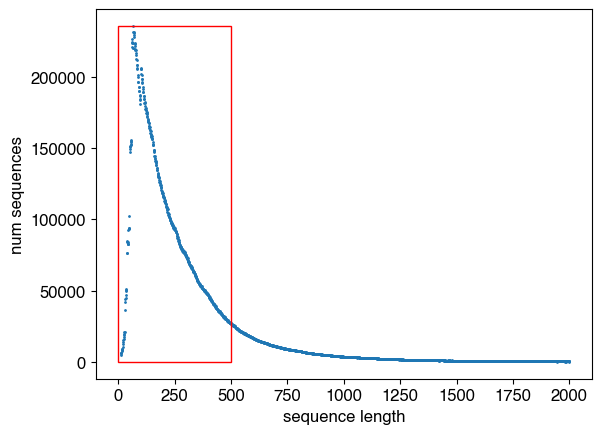

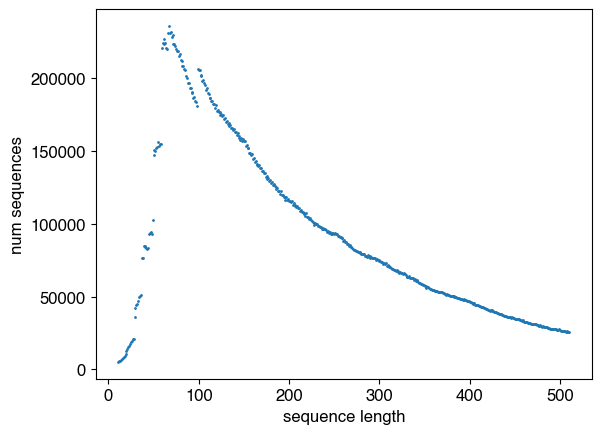

In [6]:
# what is the sequence length distribution in uniref50?

length_counts = uniref_sequences.apply(lambda x: len(x)).value_counts().sort_index()
window = 500

fig, ax = plt.subplots()
plt.scatter(x=length_counts.index, y=length_counts, s=1)
rect = patches.Rectangle(
    (window, 0),
    -window,
    length_counts.max(),
    linewidth=1,
    edgecolor="r",
    facecolor="none",
)
ax.add_patch(rect)
plt.xlabel("sequence length")
plt.ylabel("num sequences")

length_counts
fig, ax = plt.subplots()
plt.scatter(x=length_counts.index[:window], y=length_counts[:window], s=1)
plt.xlabel("sequence length")
plt.ylabel("num sequences")

In [7]:
gene_locus = next(iter(config.gene_loci_used))
gene_locus

<GeneLocus.BCR: 1>

In [8]:
# load malid seqs
malid_sequences = apply_embedding.load_sequence_embedding_content_for_fold(
    fold_id=1,
    fold_label="test",
    gene_locus=gene_locus,
    embedder_class=config.embedder,
)[0]

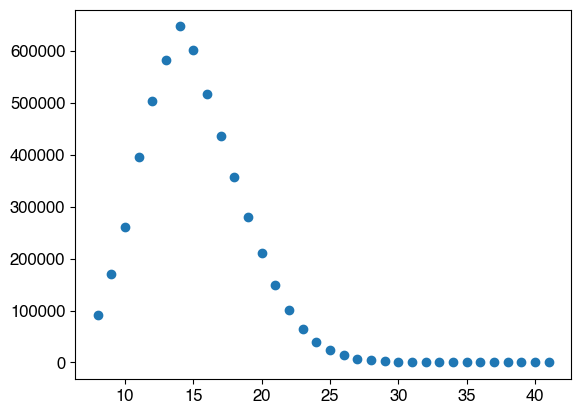

In [9]:
# what is the distribution of sequence lengths in the malid data?
length_counts = (
    pd.Series(malid_sequences).apply(lambda x: len(x)).value_counts().sort_index()
)
plt.scatter(length_counts.index, length_counts)

In [10]:
# Load and instantiate standard non-fine-tuned model.
non_fine_tuned_embedder: BaseEmbedder = config.embedder.non_fine_tuned_version()


def fetch_malid_fold_data(
    gene_locus: GeneLocus, fold_id: int, downsample: Optional[int] = None
):
    """
    For a given fold, load the fine-tuned model, as well as the sequence data for train/test/val splits
    Optionally downsample the reads
    """
    embedder = apply_embedding.load_embedding_model(
        gene_locus=gene_locus,
        fold_id=fold_id,
    )
    train_sequences, val_sequences, test_sequences = [
        apply_embedding.load_sequence_embedding_content_for_fold(
            fold_id=fold_id,
            fold_label=fold_label,
            gene_locus=gene_locus,
            embedder_class=config.embedder,
        )[0]
        for fold_label in ["train_smaller", "validation", "test"]
    ]

    if downsample:
        train_sequences = np.random.choice(train_sequences, downsample)
        val_sequences = np.random.choice(val_sequences, downsample)
        test_sequences = np.random.choice(test_sequences, downsample)

    return embedder, test_sequences, val_sequences, train_sequences

{"message": "Created a temporary directory at /tmp/tmpplchqimf", "time": "2023-12-23T03:43:40.505521"}


{"message": "Writing /tmp/tmpplchqimf/_remote_module_non_scriptable.py", "time": "2023-12-23T03:43:40.513569"}


# Experiment 1: Explore all of the models from each cross validation fold
This takes approximately 2 days to run, so hidden behind a feature flag for now

In [11]:
downsample = 10000

if run_extra_analysis:
    # keep uniref set consistent throughout analysis
    uniref_sample = np.random.choice(uniref_sequences, downsample)

    results = {}
    for gene_locus in config.gene_loci_used:
        for fold_id in config.cross_validation_fold_ids:
            (
                fine_tuned_embedder,
                test_sequences,
                val_sequences,
                train_sequences,
            ) = fetch_malid_fold_data(gene_locus, fold_id, downsample)
            results[
                (gene_locus.name, fold_id, "finetune_test")
            ] = fine_tuned_embedder.calculate_cross_entropy_loss(test_sequences)
            results[
                (gene_locus.name, fold_id, "finetune_val")
            ] = fine_tuned_embedder.calculate_cross_entropy_loss(val_sequences)
            results[
                (gene_locus.name, fold_id, "finetune_train")
            ] = fine_tuned_embedder.calculate_cross_entropy_loss(train_sequences)
            results[
                (gene_locus.name, fold_id, "finetune_uniref")
            ] = fine_tuned_embedder.calculate_cross_entropy_loss(
                uniref_sample,
                # Uniref sequences are very long, so we need to use lower batch size
                batch_size=10,
            )
            results[
                (gene_locus.name, fold_id, "base_test")
            ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(test_sequences)
            results[
                (gene_locus.name, fold_id, "base_val")
            ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(val_sequences)
            results[
                (gene_locus.name, fold_id, "base_train")
            ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(train_sequences)
            results[
                (gene_locus.name, fold_id, "base_uniref")
            ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(
                uniref_sample,
                # Uniref sequences are very long, so we need to use lower batch size
                batch_size=10,
            )

In [12]:
if run_extra_analysis:
    summary = (
        pd.Series(results)
        .reset_index()
        .rename(
            columns={
                "level_0": "gene_locus",
                "level_1": "fold",
                "level_2": "experiment",
                0: "loss",
            }
        )
    )
    summary["perplexity"] = np.exp(summary["loss"])
    summary.to_csv(
        config.paths.fine_tuned_embedding_dir / "cross_validation_loss_analysis.csv"
    )
    summary["model"] = summary["experiment"].apply(lambda x: x.split("_")[0])
    summary["dataset"] = summary["experiment"].apply(lambda x: x.split("_")[1])
    display(summary.drop("experiment", axis=1))
    display(
        summary.groupby(["gene_locus", "experiment"]).agg(
            {"loss": "mean", "perplexity": "mean"}
        )
    )

In [13]:
if run_extra_analysis:
    plt.figure()
    sns.stripplot(x="loss", y="experiment", hue="gene_locus", data=summary)
    plt.figure()
    sns.stripplot(
        y="perplexity",
        x="model",
        hue="dataset",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))

    plt.figure()
    sns.stripplot(
        y="loss",
        x="model",
        hue="dataset",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("cross entropy loss")

    plt.figure()
    sns.stripplot(
        y="loss",
        x="model",
        hue="gene_locus",
        data=summary,
        palette="Paired",
        order=["base", "finetune"],
    )
    plt.legend(bbox_to_anchor=(1, 1))
    plt.ylabel("cross entropy loss")

# Experiment 2: Only use -1 fold model
- Use validation set of sequences from the -1 fold model
- Add 20 bootstrap samples of 1000 sequences
- Make figure with confidence intervals

In [14]:
results = {}
for gene_locus in config.gene_loci_used:
    fine_tuned_embedder = apply_embedding.load_embedding_model(
        gene_locus=gene_locus,
        fold_id=-1,
    )
    print(
        fine_tuned_embedder,
        fine_tuned_embedder.embedder_sequence_content,
        non_fine_tuned_embedder,
        non_fine_tuned_embedder.embedder_sequence_content,
    )
    val_sequences = apply_embedding.load_sequence_embedding_content_for_fold(
        fold_id=-1,
        fold_label="validation",
        gene_locus=gene_locus,
        embedder_class=config.embedder,
    )[0]
    for i in range(20):
        print(i)
        val_sample = np.random.choice(val_sequences, 1000)
        uniref_sample = np.random.choice(uniref_sequences, 1000)
        results[
            (gene_locus.name, i, "best", "validation")
        ] = fine_tuned_embedder.calculate_cross_entropy_loss(val_sample)
        results[
            (gene_locus.name, i, "best", "uniref")
        ] = fine_tuned_embedder.calculate_cross_entropy_loss(
            uniref_sample,
            # Uniref sequences are very long, so we need to use lower batch size
            batch_size=10,
        )
        results[
            (gene_locus.name, i, "base", "validation")
        ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(val_sample)
        results[
            (gene_locus.name, i, "base", "uniref")
        ] = non_fine_tuned_embedder.calculate_cross_entropy_loss(
            uniref_sample,
            # Uniref sequences are very long, so we need to use lower batch size
            batch_size=10,
        )

<malid.embedders.biotransformers.Esm2FineTunedEmbedderCDR3Only object at 0x7ef9a1f84a30> EmbedderSequenceContent.CDR3 <malid.embedders.biotransformers.Esm2EmbedderCDR3Only object at 0x7ef7bc2179d0> EmbedderSequenceContent.CDR3


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


<malid.embedders.biotransformers.Esm2FineTunedEmbedderCDR3Only object at 0x7ef9a8e3ff10> EmbedderSequenceContent.CDR3 <malid.embedders.biotransformers.Esm2EmbedderCDR3Only object at 0x7ef7bc2179d0> EmbedderSequenceContent.CDR3


0


1


2


3


4


5


6


7


8


9


10


11


12


13


14


15


16


17


18


19


In [15]:
bootstraps = (
    pd.Series(results)
    .reset_index()
    .rename(
        columns={
            "level_0": "locus",
            "level_1": "iteration",
            "level_2": "model",
            "level_3": "dataset",
            0: "cross_val_entropy",
        }
    )
)

# perplexity = 2^{cross entropy loss}
bootstraps["perplexity"] = np.exp2(bootstraps["cross_val_entropy"])

bootstraps["model"] = bootstraps["model"].map(
    {"best": "Fine-tuned LLM", "base": "Base LLM"}
)
bootstraps.loc[
    (bootstraps["locus"] == "BCR") & (bootstraps["dataset"] == "validation"), "Dataset"
] = "BCR sequences"
bootstraps.loc[
    (bootstraps["locus"] == "TCR") & (bootstraps["dataset"] == "validation"), "Dataset"
] = "TCR sequences"
bootstraps.loc[bootstraps["dataset"] == "uniref", "Dataset"] = "Uniref50 sequences"

In [16]:
bootstraps.to_csv(
    config.paths.output_dir / f"fine_tuning.catastrophic_forgetting_analysis.csv"
)

In [17]:
# We can resume from here by reloading from disk
bootstraps = pd.read_csv(
    config.paths.output_dir / f"fine_tuning.catastrophic_forgetting_analysis.csv",
    index_col=0,
)
bootstraps

,locus,iteration,model,dataset,cross_val_entropy,perplexity,Dataset
0,BCR,0,Fine-tuned LLM,validation,0.545129,1.459150,BCR sequences
1,BCR,0,Fine-tuned LLM,uniref,0.391348,1.311618,Uniref50 sequences
2,BCR,0,Base LLM,validation,0.478601,1.393391,BCR sequences
3,BCR,0,Base LLM,uniref,0.362208,1.285392,Uniref50 sequences
4,BCR,1,Fine-tuned LLM,validation,0.521342,1.435289,BCR sequences
...,...,...,...,...,...,...,...
155,TCR,18,Base LLM,uniref,0.357411,1.281125,Uniref50 sequences
156,TCR,19,Fine-tuned LLM,validation,0.402738,1.322015,TCR sequences
157,TCR,19,Fine-tuned LLM,uniref,0.365246,1.288101,Uniref50 sequences
158,TCR,19,Base LLM,validation,0.452799,1.368693,TCR sequences


In [18]:
bootstraps.groupby(["locus", "model", "dataset"]).agg("mean")

{"message": "/tmp/ipykernel_3251939/579823847.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.\n  bootstraps.groupby([\"locus\", \"model\", \"dataset\"]).agg(\"mean\")\n", "time": "2023-12-23T14:40:19.269079"}


iteration  cross_val_entropy  perplexity
locus model          dataset                                             
BCR   Base LLM       uniref            9.5           0.355534    1.279463
                     validation        9.5           0.482121    1.396797
      Fine-tuned LLM uniref            9.5           0.384269    1.305203
                     validation        9.5           0.535491    1.449459
TCR   Base LLM       uniref            9.5           0.355553    1.279478
                     validation        9.5           0.450542    1.366555
      Fine-tuned LLM uniref            9.5           0.368501    1.291013
                     validation        9.5           0.404922    1.324028

In [19]:
# borrow color mapping for disease color palette
colors = list(helpers.disease_color_palette.values())
color_mapping = dict(
    zip(
        bootstraps.Dataset.sort_values().unique(),
        colors[: bootstraps.Dataset.nunique()],
    )
)
color_mapping.keys()

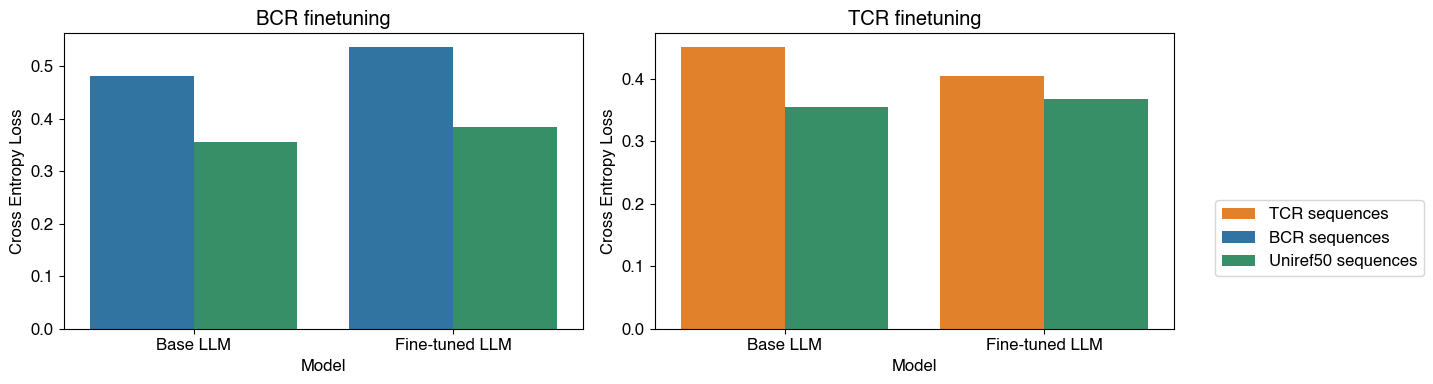

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

if "BCR sequences" in color_mapping:
    sns.barplot(
        x="model",
        y="cross_val_entropy",
        hue="Dataset",
        order=["Base LLM", "Fine-tuned LLM"],
        hue_order=["BCR sequences", "Uniref50 sequences"],
        data=bootstraps.loc[bootstraps.locus == "BCR"],
        palette=[color_mapping[i] for i in ["BCR sequences", "Uniref50 sequences"]],
        ax=ax[0],
        errorbar=None,
    )
    ax[0].set_ylabel("Cross Entropy Loss")
    ax[0].set_xlabel("Model")
    ax[0].set_title("BCR finetuning")
    ax[0].get_legend().remove()

if "TCR sequences" in color_mapping:
    sns.barplot(
        x="model",
        y="cross_val_entropy",
        hue="Dataset",
        order=["Base LLM", "Fine-tuned LLM"],
        hue_order=["TCR sequences", "Uniref50 sequences"],
        data=bootstraps.loc[bootstraps.locus == "TCR"],
        palette=[color_mapping[i] for i in ["TCR sequences", "Uniref50 sequences"]],
        ax=ax[1],
        errorbar=None,
    )
    ax[1].set_ylabel("Cross Entropy Loss")
    ax[1].set_xlabel("Model")
    ax[1].set_title("TCR finetuning")
    ax[1].get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
indexes = [labels.index(x) for x in set(labels)]
labels = [labels[i] for i in indexes]
lines = [lines[i] for i in indexes]

fig.legend(lines, labels, bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
genetools.plots.savefig(
    fig,
    config.paths.output_dir
    / f"fine_tuning.catastrophic_forgetting_analysis_cross_entropy_loss.png",
    dpi=300,
)

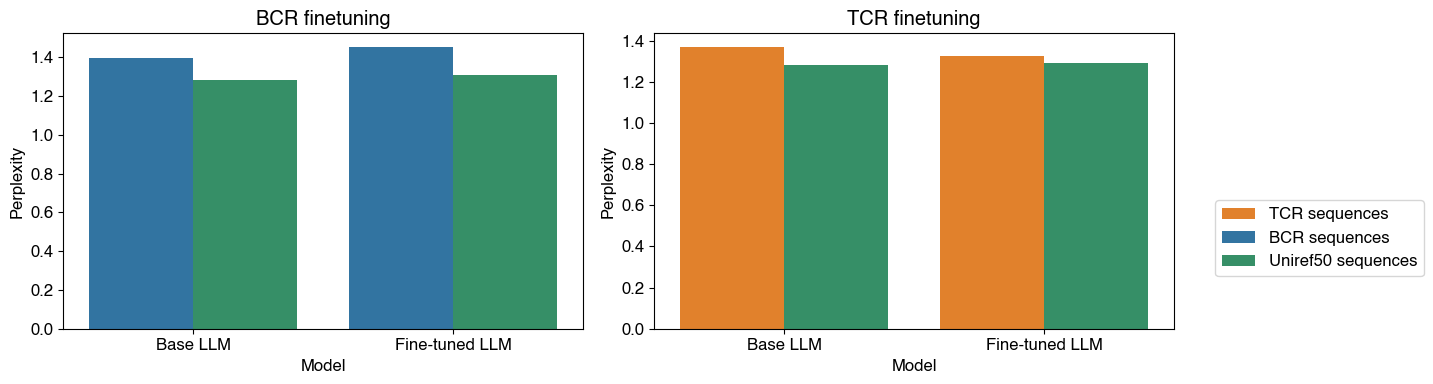

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

if "BCR sequences" in color_mapping:
    sns.barplot(
        x="model",
        y="perplexity",
        hue="Dataset",
        order=["Base LLM", "Fine-tuned LLM"],
        hue_order=["BCR sequences", "Uniref50 sequences"],
        data=bootstraps.loc[bootstraps.locus == "BCR"],
        palette=[color_mapping[i] for i in ["BCR sequences", "Uniref50 sequences"]],
        ax=ax[0],
        errorbar=None,
    )
    ax[0].set_ylabel("Perplexity")
    ax[0].set_xlabel("Model")
    ax[0].set_title("BCR finetuning")
    ax[0].get_legend().remove()

if "TCR sequences" in color_mapping:
    sns.barplot(
        x="model",
        y="perplexity",
        hue="Dataset",
        order=["Base LLM", "Fine-tuned LLM"],
        hue_order=["TCR sequences", "Uniref50 sequences"],
        data=bootstraps.loc[bootstraps.locus == "TCR"],
        palette=[color_mapping[i] for i in ["TCR sequences", "Uniref50 sequences"]],
        ax=ax[1],
        errorbar=None,
    )
    ax[1].set_ylabel("Perplexity")
    ax[1].set_xlabel("Model")
    ax[1].set_title("TCR finetuning")
    ax[1].get_legend().remove()

lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
indexes = [labels.index(x) for x in set(labels)]
labels = [labels[i] for i in indexes]
lines = [lines[i] for i in indexes]

fig.legend(lines, labels, bbox_to_anchor=(1.2, 0.5))

fig.tight_layout()
genetools.plots.savefig(
    fig,
    config.paths.output_dir
    / f"fine_tuning.catastrophic_forgetting_analysis_perplexity.png",
    dpi=300,
)